In [1]:
%matplotlib notebook

import numpy as np
import tensorflow as tf
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output, display
from scipy.ndimage import gaussian_filter
from scipy.spatial import distance
from sklearn.cluster import KMeans
import multiprocessing
from functools import partial
import time

import wolff

# Track calculation errors
np.seterr('raise')

tf.debugging.set_log_device_placement(True)

In [2]:
mem_data = np.load("data/neuro_mem3.npy") # trials by timesteps by neurons

In [3]:
angles = np.load("data/initial_angles_cued3.npy")
# Convert to radians
angles = angles / 360 * 2 * np.pi

In [5]:
# 'Scale' angles
angles = angles * 2

In [4]:
# K-means over trials
cut_data = mem_data[:, :500, :] # trials by 500 by neurons
num_channels = 17
neurons = np.mean(cut_data, 1).T # neurons by trials
kmeans = KMeans(n_clusters=num_channels, n_init=20, n_jobs=10, tol=1e-20).fit(neurons)

In [15]:
# K-means group assignment
data = np.empty((mem_data.shape[0], num_channels, mem_data.shape[1])) # trials by num_channels by timesteps
for channel in range(num_channels):
    clear_output(wait=True)
    print(str(channel + 1) + "/" + str(num_channels))
    data[:, channel, :] = np.mean(mem_data[:, :, kmeans.labels_ == channel], axis=2)

17/17


In [16]:
# Add noise to prevent division by zero errors in covdiag()
data += np.random.normal(scale=0.5, size=(data.shape[0], data.shape[1], data.shape[2]))

In [17]:
# Preserve only the first 1300 timesteps
# data = data[:, :, :1300]

# Preserve only the first 500 timesteps
data = data[:, :, :500]

In [18]:
bin_width = np.pi / 6
angspace = np.arange(-0.5*np.pi, 0.5*np.pi+bin_width, bin_width)
# angspace = np.arange(-np.pi, np.pi+bin_width, bin_width)

In [19]:
num_trials = data.shape[0]
num_channels = data.shape[1]
timesteps = data.shape[2]

# A covariance matrix for every trial, for every timestep
sigma = np.empty((num_trials, timesteps, num_channels, num_channels))

In [20]:
# Fill sigma in a parallel fashion
def cov_mats(trl):
    trn_dat = data[np.arange(num_trials) != trl, :, :]
    sigma = np.empty((timesteps, num_channels, num_channels))
    for ti in range(timesteps):
        sigma[ti, :, :] = np.linalg.pinv(wolff.covdiag(trn_dat[:, :, ti]))
        
    return sigma

if __name__ == '__main__':
    with multiprocessing.Pool(20) as pool:
        calcs = pool.imap(cov_mats, [trl for trl in range(num_trials)])
        for trl in range(num_trials):
            sigma[trl, :, :, :] = next(calcs)
            clear_output(wait=True)
            print(trl+1)

# for trl in range(num_trials):
#     trn_dat = data[np.arange(num_trials) != trl, :, :]
#     for ti in range(timesteps):
#         sigma[trl, ti, :, :] = wolff.covdiag(trn_dat[:, :, ti])

350


In [21]:
theta = angles
cosines = np.expand_dims(np.cos(angspace), (1, 2))
cross_cos_amp = np.empty((num_trials, timesteps, timesteps))

def amps(trl):
    distances = np.empty((len(angspace), timesteps, timesteps))
    
    trn_dat = data[np.arange(num_trials) != trl, :, :]
    trn_angle = theta[np.arange(num_trials) != trl]
    for b in range(len(angspace)):
#         print(str(b+1) + "/" + str(len(angspace)))
        angle_dists = np.abs(np.angle(np.exp(1j*trn_angle) / np.exp(1j*(theta[trl] - angspace[b]))))
        m = np.mean(trn_dat[angle_dists < bin_width, : , :], 0)
        for ti in range(timesteps):
#             clear_output(wait=True)
#             print(str(trl+1) + "/" + str(num_trials) + "; " + str(b+1) + "/" + str(len(angspace)) + "; " + str(ti+1) + "/" + str(timesteps))
#             distances[trl, :, ti] = np.array([distance.mahalanobis(means, data[trl, :, ti], sigma) for means in m[:, :, ti]])            
#             distances[b, ti, :] = wolff.mahalanobis(data[trl].T, m[:, ti].T, sigma[trl, ti, :, :])
            distances[b, ti, :] = np.array([distance.mahalanobis(datum, m[:, ti].T, sigma[trl, ti, :, :]) for datum in data[trl,].T])
    
    mean_centred = distances - np.mean(distances, 0)
    return -np.mean(cosines * mean_centred, 0)
    
#     return -np.mean(cosines * distances, 0)

start_t = time.time()

if __name__ == '__main__':
    with multiprocessing.Pool(40) as pool:
        calcs = pool.imap(amps, [trl for trl in range(num_trials)])
        for trl in range(num_trials):
            clear_output(wait=True)
            print(str(trl+1) + "/" + str(num_trials))
            cross_cos_amp[trl, :, :] = next(calcs)
            
end_t = time.time()
print(end_t - start_t)

350/350
545.5444071292877


In [13]:
with tf.device('/GPU:1'):
    cosines = tf.Variable(tf.reshape(tf.math.cos(angspace), [-1, 1, 1]), dtype='float64')
    distances = tf.Variable(tf.zeros([angspace.shape[0], timesteps, timesteps], dtype='float64'))
    cross_cos_amp = tf.Variable(tf.zeros([num_trials, timesteps, timesteps], dtype='float64'))

@tf.function
def cross_similarity(data, theta, angspace, bin_width, sigma):
    tf.print("hi")
    num_trials = data.shape[0]
    num_channels = data.shape[1]
    timesteps = data.shape[2]
    
#     cosines = np.expand_dims(np.cos(angspace), (1, 2))
#     distances = np.empty((len(angspace), timesteps, timesteps))
#     cross_cos_amp = np.empty((num_trials, timesteps, timesteps))
    
    for trl in range(num_trials):
        print(trl)
        tf.print(trl)
        trn_dat = tf.boolean_mask(data, np.arange(num_trials) != trl)
        trn_angle = tf.boolean_mask(theta, np.arange(num_trials) != trl)
        
        complex_a = tf.dtypes.complex(tf.constant(0, dtype='float64'), trn_angle)
#         for b in range(len(angspace)):
        for b in range(angspace.shape[0]):
    #         print(str(b+1) + "/" + str(len(angspace)))
#             angle_dists = np.abs(np.angle(np.exp(1j*trn_angle) / np.exp(1j*(theta[trl] - angspace[b]))))

            complex_b = tf.dtypes.complex(tf.constant(0, dtype='float64'), theta[trl] - angspace[b])

            angle_dists = tf.math.abs(tf.math.angle(tf.math.exp(complex_a) / tf.math.exp(complex_b)))
            m = tf.reduce_mean(tf.boolean_mask(trn_dat, angle_dists < bin_width), 0)
            
            calc_dist_part = lambda x: calc_dist(tf.transpose(data[trl]), x[0], x[1])
            distances[b].assign(tf.map_fn(calc_dist_part, (tf.transpose(m), sigma[trl]), dtype=tf.float64))
            
#             for ti in range(timesteps):
#     #             clear_output(wait=True)
#     #             print(str(trl+1) + "/" + str(num_trials) + "; " + str(b+1) + "/" + str(len(angspace)) + "; " + str(ti+1) + "/" + str(timesteps))
#     #             distances[trl, :, ti] = np.array([distance.mahalanobis(means, data[trl, :, ti], sigma) for means in m[:, :, ti]])            
# #                 distances[b, ti, :] = wolff.mahalanobis(data[trl].T, m[:, ti].T, sigma[trl, ti, :, :])
#                 distances[b, ti, :].assign(mahalanobis(tf.transpose(data[trl]), tf.transpose(m[:, ti]), sigma[trl, ti, :, :]))
# #                 distances[b, ti, :] = np.array([distance.mahalanobis(datum, m[:, ti].T, sigma[trl, ti, :, :]) for datum in data[trl,].T])

#         mean_centred = distances - np.mean(distances, 0)
        mean_centred = distances - tf.math.reduce_mean(distances, 0)
#         cross_cos_amp[trl, :, :] = -np.mean(cosines * mean_centred, 0)
        cross_cos_amp[trl, :, :].assign(-tf.reduce_mean(cosines * mean_centred, 0))
    
    tf.print(cross_cos_amp)
        
    return cross_cos_amp

def calc_dist(dat, m, sigma):
    return mahalanobis(dat, m, sigma)
    

def mahalanobis(u, v, VI):
    # u.shape: timesteps by channels
    # v.shape: channels
    # VI.shape: channels by channels

    # delta.shape: timesteps by channels
    delta = u - v
    
    # dot(delta, VI).shape: timesteps by channels
    # delta.T.shape: channels by timesteps
    # dot(dot(delta, VI), delta.T).shape: bins by bins
#     return np.sqrt(np.diag(np.dot(np.dot(delta, VI), delta.T)))
    return tf.sqrt(tf.linalg.diag_part(tf.matmul(delta @ VI, delta, transpose_b=True)))

Executing op Cos in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op Reshape in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:1


In [ ]:
## tf.config.experimental_run_functions_eagerly(False)

start_t = time.time()
with tf.device('/GPU:1'):
    angspace_T = tf.convert_to_tensor(angspace)
    cross_cos_amp = cross_similarity(data, angles, angspace_T, bin_width, sigma)

end_t = time.time()

print(end_t - start_t)

In [77]:
# tensor = tf.Variable(tf.zeros([2, 3]))
# tensor[:, 0].assign(tf.constant([3., 3.]))
# tensor * tf.reshape(tf.constant([2., 2.]), [2, 1])

# data_T = tf.convert_to_tensor(data)
tf.dtypes.complex(tf.constant(0, dtype='float64'), data_T).shape

TensorShape([350, 17, 1300])

In [22]:
c = np.mean(cross_cos_amp, 0)

In [13]:
# Matlab-shared Nengo data
# scipy.io.savemat('wolff/nengo_mem.mat', dict(data=data, angles=angles, bin_width=bin_width, angspace=angspace))

<IPython.core.display.Javascript object>


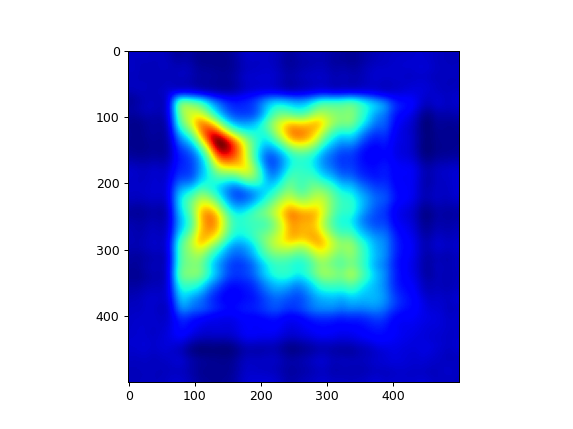

In [23]:
plt.imshow(gaussian_filter((c + c.T) / 2, sigma=8), cmap='jet')

<IPython.core.display.Javascript object>


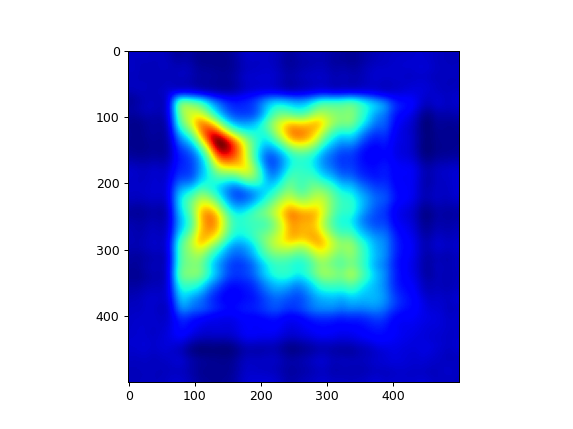

In [23]:
plt.imshow(gaussian_filter((c + c.T) / 2, sigma=8), cmap='jet')

<IPython.core.display.Javascript object>


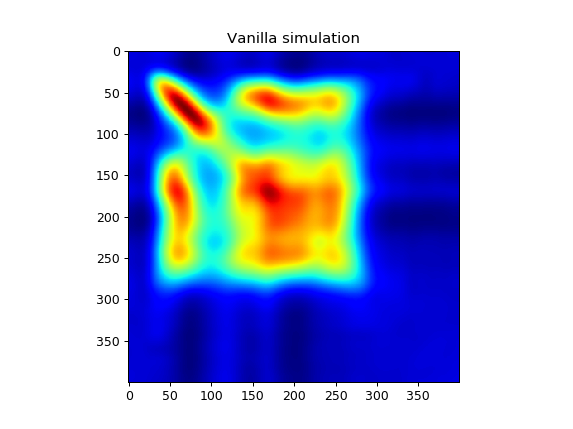

In [40]:
plt.close()

plt.title("Vanilla simulation")
plt.imshow(gaussian_filter((c + c.T) / 2, sigma=8), cmap='jet')
# plt.imshow((c + c.T) / 2, cmap='jet')